# LSTM (Long Short-Term Memory) ile Hisse Senedi Fiyatı Tamini

Projemiz 5 aşamada gerçekleştirilecektir:

* İş Problemi
* Veriyi Anlamak
* Veriyi Hazırlamak
* Modelleme
* Değerlendirme


# 1. İş Problemi

Bu projede Tesla şirketinin borsadaki hisse senedi fiyatlarını tahmin etmeye çalışacağız. Elimizdeki veri setinde Tesla hisse senetlerinin 2010 ila 2020 arasındaki verileri mevcuttur. 10 yıllık veriyi modelimizde eğitip gelecekteki hisse senedi fiyatları hakkında LSTM yöntemini kullanarak tahminlerde bulunacağız.

Veri setindeki değişkenlere ait bilgiler aşağıdaki gibidir:
* **Date**: İlgili işlem gününün tarihi
* **Open**: İlgili işlem gününe ait hisse başlangıç fiyatı
* **High**: İlgili işlem gününe ait hissenin gördüğü en yüksek fiyat
* **Low**: İlgili işlem gününe ait hissenin gördüğü en düşük fiyat
* **Close**: İlgili işlem gününe ait hisse senedinin kapanış fiyatı
* **Adj Close**: İlgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatı
* **Volume**: İlgili işlem gününe ait işlem hacmi bilgisi

In [29]:
# Veriyi okumak ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt




# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılan kütüphaneler
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# 2. Veriyi Anlamak

In [30]:
# Veriyi okuma
df = pd.read_csv('/content/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [31]:
def check_df(dataframe, size=5):
    print('\n\n--- Shape -----------------------------------------------------------------------')
    print(dataframe.shape)
    print('\n\n--- Types -----------------------------------------------------------------------')
    print(dataframe.dtypes)
    print('\n\n--- Head ------------------------------------------------------------------------')
    print(dataframe.head(size))
    print('\n\n--- Tail ------------------------------------------------------------------------')
    print(dataframe.tail(size))
    print('\n\n--- NA --------------------------------------------------------------------------')
    print(dataframe.isnull().sum())
    print('\n\n--- Quantiles -------------------------------------------------------------------')
    print(df.drop('Date', axis=1).quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

In [34]:
check_df(df)



--- Shape -----------------------------------------------------------------------
(2416, 7)


--- Types -----------------------------------------------------------------------
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


--- Head ------------------------------------------------------------------------
        Date       Open   High        Low      Close  Adj Close    Volume
0 2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1 2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2 2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3 2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4 2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900


--- Tail ------------------------------------------------------------------------


# 3. Veriyi Hazırlama

In [33]:
# Object olan date değişken tipini datetime yapıyoruz
df['Date'] = pd.to_datetime(df['Date'])

In [49]:
# Sadece Close değişkenine göre bir eğitim yapacağız, bunun için tarih ve close değişkeninden yeni bir df oluşturuyoruz
tesla_df = df[['Date', 'Close']]
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [37]:
print('Min Tarih: ', tesla_df['Date'].min())
print('Max Tarih: ', tesla_df['Date'].max())

Min Tarih:  2010-06-29 00:00:00
Max Tarih:  2020-02-03 00:00:00


In [52]:
# Date değişkenini index yapacağız ve df içindeki kolonunu sileceğiz
tesla_df.index = tesla_df['Date']
tesla_df.drop('Date', axis=1, inplace=True)
tesla_df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


In [53]:
# İlerideki bölümlerde ihtiyaç olacağından dolayı result_df adı altında bir df'te saklıyoruz
result_df = tesla_df.copy()

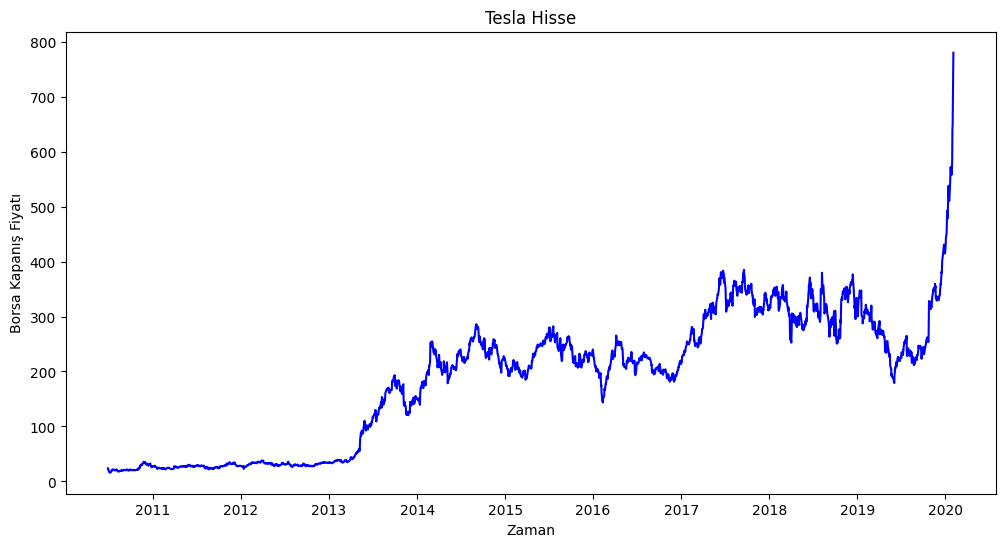

In [41]:
# Şu ana kadar olan kısmı görselleştireceğiz
plt.figure(figsize=(12,6))
plt.plot(tesla_df['Close'], color='blue')
plt.ylabel('Borsa Kapanış Fiyatı')
plt.title('Tesla Hisse')
plt.xlabel('Zaman')
plt.show()

In [56]:
# Modele sokmadan önce verileri numpy arrayine çevirmemiz gerekiyor
tesla_df = tesla_df.values
tesla_df[0:5]

array([[23.89],
       [23.83],
       [21.96],
       [19.2 ],
       [16.11]], dtype=float32)

In [57]:
# Sinir ağlarında genel olarak kullanılan veri tipi olan float32'e dönüştürme yapıyoruz
tesla_df = tesla_df.astype('float32')

In [58]:
# Verimizin son hali
type(tesla_df), tesla_df.dtype

(numpy.ndarray, dtype('float32'))

In [59]:
# train-test ayrımının yapılması
# Zaman serilerinde sklearn içinde test train split fonksiyonunu kullanamayız. Çünkü bu fonksiyon
# verileri random olarak seçiyor ve buda zaman bağlamını ve mantık aktarımını bozuyor.
# Bu sebepten dolayı bunu kendi yazdığımız basit bir fonksiyon ile yapacağız.

def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [60]:
train, test, pos = split_data(tesla_df, 0.20)
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [61]:
# Standartlaştırma işlemlerini yapıyoruz

scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

print(train[0:5], test[0:5])

[[0.02191224]
 [0.02174973]
 [0.01668472]
 [0.0092091 ]
 [0.00083966]] [[0.25685903]
 [0.24829045]
 [0.25511202]
 [0.24978784]
 [0.2465767 ]]


## Neden Standartlaştırma işlemi yaparız?

Sinir ağlarında standartlaştırma işlemi yapılmasının birkaç sebebi vardır:

* **Hızlı Öğrenme:** Sinir ağları, özellikler arasındaki ölçek farklılıklarına oldukça duyarlıdır. Eğer bir özellik diğerinden çok daha büyük veya küçük değerlere sahipse, bu ağın eğitimini olumsuz etkileyebilir. Standartlaştırma, tüm özellikleri benzer ölçeklere getirerek, sinir ağlarının daha hızlı öğrenmesine ve daha iyi performans göstermesine yardımcı olur.

* **Optimizasyon Stabilitesi:** Sinir ağları, genellikle bir optimizasyon algoritması (örneğin, stokastik gradyan inişi) kullanılarak eğitilir. Bu optimizasyon algoritmaları, genellikle özelliklerin benzer ölçeklere sahip olduğu durumlarda daha iyi çalışır. Standartlaştırma, optimizasyon algoritmalarının daha stabil bir şekilde çalışmasına yardımcı olabilir.

* **Model Genellemesi:** Standartlaştırma, modelin farklı veri setlerine daha iyi genelleme yapabilmesine yardımcı olabilir. Eğer eğitim ve test veri setleri arasında ölçek farklılıkları varsa, modelin doğruluğu olumsuz etkilenebilir. Standartlaştırma, bu tür farklılıkları azaltarak daha iyi genelleme yapılmasına katkı sağlar.

Standartlaştırma işlemi genellikle özellik değerlerini ortalaması sıfır, standart sapması bir olan bir normal dağılıma dönüştürerek yapılır. Bu işlem, genelde aşağıdaki formül ile uygulanır:

**standartlaştırılmış değer = (orjinal değer - ortalama) / standart sapma**

Bunu uygulayarak verileri standardize etmek, sinir ağlarının daha iyi performans göstermesini sağlayabilir ve eğitimi daha stabil hale getirebilir.

In [62]:
# Geçmiş veriler ile feature yaratma

def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

## LSTM'lerde neden geçmiş verilerle feature yaratırız?

LSTM (Uzun Kısa Vadeli Bellek) gibi rekürrent sinir ağları, geçmiş verilerle feature yaratmanın temel amacı, zaman serileri analizlerindeki zaman bağımlılıklarını modelleyerek gelecekteki değerleri daha iyi tahmin etmeye çalışmaktır. İşte bu nedenlerden dolayı geçmiş verilerle feature yaratılır:

* **Zaman Bağımlılıklarını Yakalamak:** Zaman serileri genellikle geçmiş değerlere bağımlıdır. Yani, bir olayın meydana gelmesi bir önceki olayın gerçekleşmiş olmasına bağlıdır. LSTM, önceki zaman adımlarındaki bilgileri saklamak ve kullanmak için tasarlanmış bir yapıya sahiptir. Bu özellik sayesinde, geçmiş verilere dayanarak zaman serilerindeki karmaşık zaman bağımlılıklarını öğrenme yeteneğine sahiptir.

* **Patternleri Anlama:** LSTM, geçmiş verilerle öğrendiği desenleri hatırlayabilir ve bu desenleri kullanarak gelecekteki değerleri tahmin edebilir. Örneğin, hisse senedi fiyatları gibi finansal verilerde, geçmiş fiyat hareketlerinin belirli desenleri olabilir ve LSTM bu desenleri öğrenerek gelecekteki fiyat hareketlerini tahmin edebilir.

* **Özellik Mühendisliği İhtiyacını Azaltmak:** LSTM'nin kendisi geçmiş bilgileri ele alabilir, bu da özellik mühendisliği yapma ihtiyacını azaltır. Önceki zaman adımlarındaki bilgiler, model tarafından öğrenilebilir, böylece elle özellik mühendisliği yapmak gerekmez.

Örneğin, hisse senedi tahmininde, bir gün önceki kapanış fiyatı, bir hafta önceki en yüksek fiyat, bir ay önceki ortalama işlem hacmi gibi geçmiş verilere dayalı özellikler oluşturabilirsiniz. Bu geçmiş veriler, modelin trendleri ve desenleri daha iyi anlamasına yardımcı olabilir.

In [63]:
lookback = 20 #20 günlül veri alarak

In [65]:
# Train
x_train, y_train = create_features(train, lookback)

# Test
x_test, y_test = create_features(test, lookback)

In [66]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [67]:
x_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [68]:
y_train[0:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

In [69]:
# Veri setlerini 3 boyutlu yapıya getirme
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


## **Sinir ağlarının giriş katmanı neden 3 boyutlu yapıda ister?**

LSTM gibi rekürrent sinir ağlarını kullanırken giriş verisinin üç boyutlu olmasını sağlamak içindir. LSTM modelleri, üç boyutlu bir giriş yapısını beklerler: (örnek sayısı, zaman adımları, özellik sayısı).

Özellikle tek değişkenli zaman serileri kullanılıyorsa, (örnek sayısı, zaman adımları) şeklindeki iki boyutlu bir giriş yerine LSTM'nin beklediği üç boyutlu yapıyı elde etmek için np.reshape() kullanılır. Burada:

* **Örnek sayısı:** Veri setinizdeki örnek sayısı.

* **Zaman adımları:** Her bir örnek için zaman adımlarının sayısı (örneğin, 20 gün).

* **Özellik sayısı:** Her bir zaman adımındaki özellik sayısı (Örneğin, sadece kapanış fiyatı kullanılıyorsa 1, açılış, düşük, yüksek, kapanış kullanılıyorsa 4).

Bu nedenle, np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1])) ifadesi, x_train array'ini üç boyutlu bir yapıya dönüştürür ve (örnek sayısı, 1, özellik sayısı) şeklinde bir yapıya getirir. Benzer bir işlem y_train ve test verileri için de uygulanmaktadır.

Bu şekilde, LSTM modeli, her bir örneği ve her bir zaman adımındaki özellikleri doğru şekilde anlamak üzere eğitilir. Eğer giriş verisi zaten üç boyutlu ise (örneğin (örnek sayısı, zaman adımları, özellik sayısı)), bu tür bir reshape işlemine ihtiyaç duyulmaz.


## **Modele birden fazla değişkeni lookback verileri ile birlikte nasıl sokabiliriz?**

Bu çalışmada sadece Close değişkeni ile eğitim yapılıyor fakat hisse senedi gibi sonuca etki edecek bir çok etken olan problemlerde birden fazla değişkene ihtiyaç olacaktır. LSTM'in istediği lookback verileriyle birlikte bunu np.dstack() fonksiyonu yardımıyla yapabiliriz.

np.dstack() fonksiyonu ile istediğiniz kadar çok değişkeni birleştirip train seti oluşturabilirsiniz. Bu fonksiyon, üç boyutlu bir array oluşturarak farklı değişkenleri üçüncü boyutta birleştirebilir.

Örneğin, Close, Open, High, ve Low gibi farklı özelliklere sahip bir veri setini birleştirebilirsiniz. Aşağıda, dört farklı özelliği birleştirerek üç boyutlu bir array oluşturan örnek bir kod bulunmaktadır:

-------------------

import numpy as np

*#Close, Open, High, Low değerleri içeren bir veri seti*

close_prices = np.array([[...], [...], ...])  *# (satır_sayısı, 20) şeklinde*

open_prices = np.array([[...], [...], ...])   *# (satır_sayısı, 20) şeklinde*

high_prices = np.array([[...], [...], ...])   *# (satır_sayısı, 20) şeklinde*

low_prices = np.array([[...], [...], ...])    *# (satır_sayısı, 20) şeklinde*


*#Dört değeri birleştirerek train seti oluşturun*

train_set = np.dstack((close_prices, open_prices, high_prices, low_prices)) *# (satır_sayısı, 20, 4) şeklinde*

-------------------

Bu durumda, her bir gözlem için 20 gün süresince Close, Open, High, ve Low değerleri olacak. Bu train setini kullanarak LSTM modelinizde çoklu değişkenli bir zaman serisi analizi gerçekleştirebilirsiniz.



# 4. Modelleme

In [70]:
# Model kurulumu
model = Sequential()
model.add(LSTM(units=50,
               activation='relu',
               input_shape=(x_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [71]:
# Model özeti
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
# Optimizasyon ve değerlendirme metriklerinin ayarlanması
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [74]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min',
                             save_best_only=True, save_weights_only=False, verbose=1)]

In [75]:
# Model fit
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=100,
                    batch_size=40,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.0150
Epoch 1: val_loss improved from inf to 0.00412, saving model to mymodel.h5
48/48 [==============================] - 2s 15ms/step - loss: 0.0150 - val_loss: 0.0041
Epoch 2/100
40/48 [========================>.....] - ETA: 0s - loss: 0.0101
Epoch 2: val_loss did not improve from 0.00412
48/48 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0043
Epoch 3/100
40/48 [========================>.....] - ETA: 0s - loss: 0.0067
Epoch 3: val_loss did not improve from 0.00412
48/48 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0042
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.0071
Epoch 4: val_loss improved from 0.00412 to 0.00408, saving model to mymodel.h5
48/48 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 5/100
38/48 [======================>.......] - ETA: 0s - loss: 0.0050
Epoch 5: val_loss impro

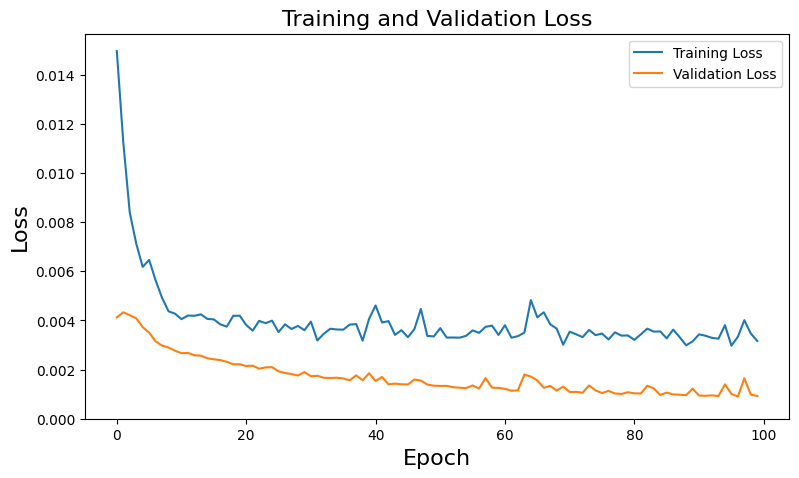

In [77]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# 5. Değerlendirme

In [78]:
loss = model.evaluate(x_test, y_test, batch_size=40)
print('\nTest Loss: %.1f%%' % (100.0 * loss))

12/12 [==============================] - 0s 2ms/step - loss: 9.2786e-04

Test Loss: 0.1%


> Yukarıdaki değer standartlaştırılmış veriler ile elde edilen model sonucudur. Fakat bu bize somut olarak anlamlı bir bilgi vermiyor. Bunun için standartlaştırma işleminin tersini yaparak loss değerini dolar karşılığını görebileceğiz.

In [79]:
# Modelimizden tahminleri alıyoruz
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

15/15 [==============================] - 0s 2ms/step


In [80]:
# Standartlaştırılmış tahmin verilerini gerçek değerlere geri dönüştürüyoruz
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [81]:
# Yukarıdaki aynı işlemi eğitilen ve test edilen veri setlerine de yapıyoruz
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [82]:
# Train RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [83]:
# Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [84]:
print(f'Train RMSE: {train_rmse}')
print(f' Test RMSE: {test_rmse}')

Train RMSE: 8.568570137023926
 Test RMSE: 18.30784797668457


> Test RMSE 19.73 olarak çıktı. Bunun anlamı; gelecekteki Tesla hisse senedi tahminlerini 19.73 dolar sapma ile tahmin edebiliriz. Veri setindeki son Tesla hisse senedi değer yaklaşık 780 dolar olduğuna göre yaklaşık yüzde 2.5 sapma ile bir gelecekteki hisse senedi fiyat tahminlerini yapabileceğimizi öngörebiliriz.

In [85]:
# Gerçek değerler ile tahmin edilen değerleri train veri seti için kıyaslama
train_prediction_df = result_df[lookback:pos]
train_prediction_df['Predicted'] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,34.890213
2010-07-29,20.350000,34.890213
2010-07-30,19.940001,34.890213
2010-08-02,20.920000,34.890213
2010-08-03,21.950001,34.890213


In [86]:
# Gerçek değerler ile tahmin edilen değerleri test veri seti için kıyaslama
test_prediction_df = result_df[pos+lookback:] # pos+lookback yani trainden sonraki kısmı aldık
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,286.591248
2018-04-04,286.940002,283.923920
2018-04-05,305.720001,288.172516
2018-04-06,299.299988,294.737701
2018-04-09,289.660004,295.534271


In [87]:
# Veri setinin en güncel tarihteki test tahminleri
test_prediction_df.tail(10)

,Close,Predicted
Date,,
2020-01-21,547.200012,516.014771
2020-01-22,569.559998,526.276917
2020-01-23,572.200012,543.547485
2020-01-24,564.820007,557.422607
2020-01-27,558.020020,561.650024
2020-01-28,566.900024,561.173767
2020-01-29,580.989990,565.958008
2020-01-30,640.809998,574.364319
2020-01-31,650.570007,599.302246


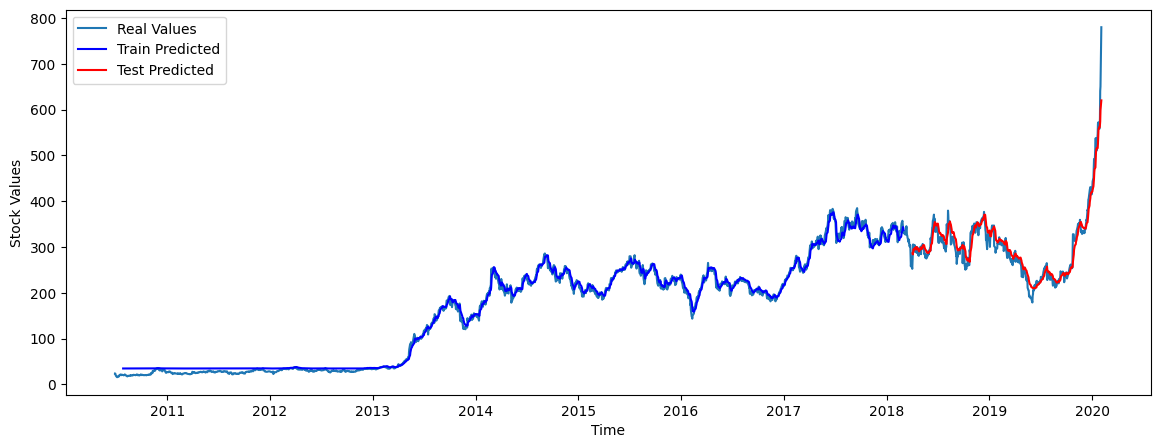

In [88]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme
plt.figure(figsize=(14, 5))
plt.plot(result_df, label='Real Values')
plt.plot(train_prediction_df['Predicted'], color='blue', label='Train Predicted')
plt.plot(test_prediction_df['Predicted'], color='red', label='Test Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()